Importing required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud,STOPWORDS
import re,string,unicodedata
import nltk

from bs4 import BeautifulSoup
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import PCA

nltk.download('wordnet')
nltk.download('stopwords')
string.punctuation
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/full stack data science specialization/Capstone 4/NetfixMoviesAndTvshowsClustering/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv",index_col='show_id')

In [ ]:
df = original_data.copy()

Understanding Data

In [ ]:
df.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
df.shape

(7787, 11)

In [ ]:
df.nunique()

type               2
title           7787
director        4049
cast            6831
country          681
date_added      1565
release_year      73
rating            14
duration         216
listed_in        492
description     7769
dtype: int64

Cleaning Data

Checking for duplicates

In [ ]:
df.duplicated().sum()

0

No duplicates in the data

Checking for missing values and handeling them

In [ ]:
df.isna().sum()

type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

Values are missings in columns director,cast,country,date_added,rating

In [ ]:
# Handling the missing values
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df[['director','cast','country']] = df[['director','cast','country']].fillna('unknown')

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [ ]:
# Top countries
df['country'].value_counts()

United States                                                   2549
India                                                            923
unknown                                                          506
United Kingdom                                                   396
Japan                                                            225
                                                                ... 
Russia, United States, China                                       1
Italy, Switzerland, France, Germany                                1
United States, United Kingdom, Canada                              1
United States, United Kingdom, Japan                               1
Sweden, Czech Republic, United Kingdom, Denmark, Netherlands       1
Name: country, Length: 682, dtype: int64

In [ ]:
# Gener of Shows and movies
df['listed_in'].value_counts()

Documentaries                                                                      334
Stand-Up Comedy                                                                    321
Dramas, International Movies                                                       320
Comedies, Dramas, International Movies                                             243
Dramas, Independent Movies, International Movies                                   215
                                                                                  ... 
Anime Series, Crime TV Shows, TV Thrillers                                           1
Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows                         1
Crime TV Shows, International TV Shows, Reality TV                                   1
International Movies, Romantic Movies, Sci-Fi & Fantasy                              1
International TV Shows, Spanish-Language TV Shows, Stand-Up Comedy & Talk Shows      1
Name: listed_in, Length: 491, dtype: int64

- There are some movies / TV shows that were filmed in multiple countries, have multiple genres associated with it.
- To simplify the analysis, let's consider only the primary country where that respective movie / TV show was filmed.
- Also, let's consider only the primary genre of the respective movie / TV show.

In [ ]:
df['country'] = df['country'].apply(lambda x : x.split(",")[0])
df['listed_in'] = df['listed_in'].apply(lambda x: x.split(",")[0])

In [ ]:
df['country'].value_counts()

United States     2877
India              956
United Kingdom     576
unknown            506
Canada             259
                  ... 
Zimbabwe             1
Namibia              1
Soviet Union         1
Iran                 1
Somalia              1
Name: country, Length: 82, dtype: int64

In [ ]:
df['listed_in'].value_counts()

Dramas                          1384
Comedies                        1074
Documentaries                    751
Action & Adventure               721
International TV Shows           689
Children & Family Movies         502
Crime TV Shows                   369
Kids' TV                         357
Stand-Up Comedy                  321
Horror Movies                    244
British TV Shows                 231
Docuseries                       193
Anime Series                     147
International Movies             114
TV Comedies                      109
Reality TV                       102
Classic Movies                    77
TV Dramas                         62
Movies                            56
Thrillers                         49
TV Action & Adventure             36
Stand-Up Comedy & Talk Shows      33
Romantic TV Shows                 28
Independent Movies                20
Anime Features                    19
Classic & Cult TV                 19
Music & Musicals                  17
T

In [ ]:
# Changing duration column to float
df['duration'] = df['duration'].apply(lambda x: int(x.split(" ")[0]))

In [ ]:
df['duration'].dtypes

dtype('int64')

In [ ]:
df[df['type']=='TV Show']['duration'].value_counts()

1     1608
2      378
3      183
4       86
5       57
6       30
7       19
8       18
9        8
10       5
11       2
12       2
15       2
13       1
16       1
Name: duration, dtype: int64

In [ ]:
df[df['type']=='Movie']['duration'].value_counts()

90     136
93     131
91     125
94     125
95     119
      ... 
214      1
182      1
224      1
233      1
191      1
Name: duration, Length: 201, dtype: int64

In [ ]:
# Changing date_added column from type object tp datetime
df['date_added'] = pd.to_datetime(df['date_added'])

In [ ]:
# First and last date of our dataset
df['date_added'].min(),df['date_added'].max()

(Timestamp('2008-01-01 00:00:00'), Timestamp('2021-01-16 00:00:00'))

In [ ]:
# Extracting month and year from date_added and then dropping the date_added column
df['month_added'] = df['date_added'].dt.month
df['year_added'] = df['date_added'].dt.year
df.drop('date_added',axis=1,inplace=True)

The ratings can be changed to age restrictions that apply on certain movies and TV shows.

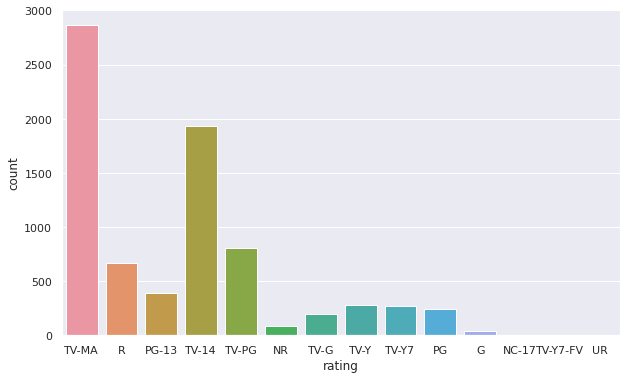

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(df['rating'])

Highest number of shows on Netflix are rated by TV-MA, followed by TV-14 and TV-PG

In [ ]:
# Age Rating
df['rating'].unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y',
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [ ]:
# Changing the values in the rating column
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

df['rating'].replace(rating_map, inplace = True)
df['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

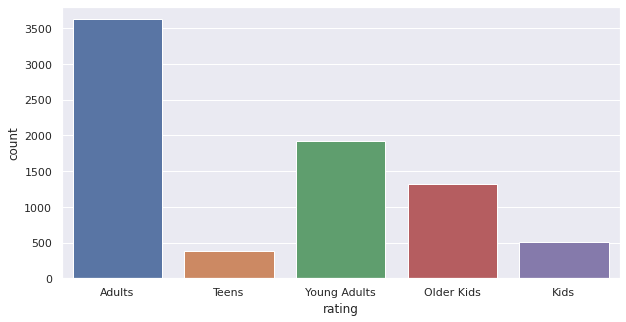

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df,x='rating')

In [ ]:
df['rating'].value_counts(normalize=True)

Adults          0.465989
Young Adults    0.247911
Older Kids      0.170631
Kids            0.065835
Teens           0.049634
Name: rating, dtype: float64

Around 50% of shows on Netflix are produced for adult audience. Followed by young adults, older kids and kids. Netflix has the least number of shows that are specifically produced for teenagers than other age groups.

Exploratory Data Analysis

Text(0.5, 1.0, 'Movie and TvShows in dataset')

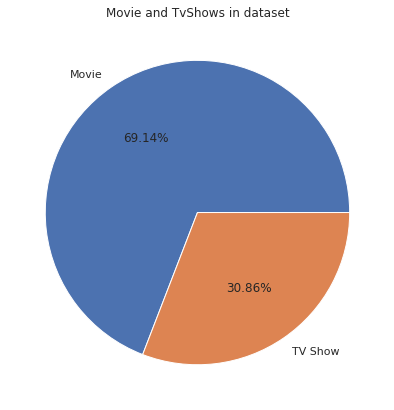

In [ ]:
plt.figure(figsize=(7,7))
df['type'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.ylabel("")
plt.title("Movie and TvShows in dataset")

- There are more movies (69.14%) than TV shows (30.86%) in the dataset.

Text(0.5, 1.0, 'Top 10 directors in dataset')

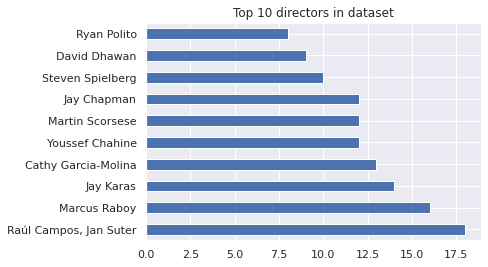

In [ ]:
# Top ten directors in dataset
df[~(df['director']=='unknown')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 directors in dataset")

Raul Campos and Jan Suter together have directed 18 movies / TV shows, higher than anyone in the dataset.

Text(0.5, 1.0, 'Top 10 countries in dataset')

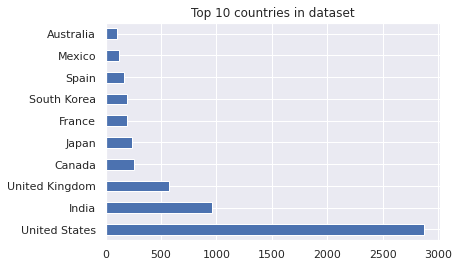

In [ ]:
# Top 10 countries with highest number of movies and shows in dataset
df[~(df['country']=='unknown')].country.value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 countries in dataset")

- The highest number of movies / TV shows were based out of the US, followed by India and UK.

In [ ]:
# % share of movies / tv shows by top 3 countries
df['country'].value_counts().nlargest(3).sum()/df.shape[0]

0.566928121383567

In [ ]:
# % share of movies / tv shows by top 10 countries
df['country'].value_counts().nlargest(10).sum()/df.shape[0]

0.7832068921177832

- The top 3 countries together account for about 56% of all movies and TV shows in the dataset.
- This value increases to about 78% for top ten countries.

Text(0.5, 1.0, 'Release Year of films in dataset')

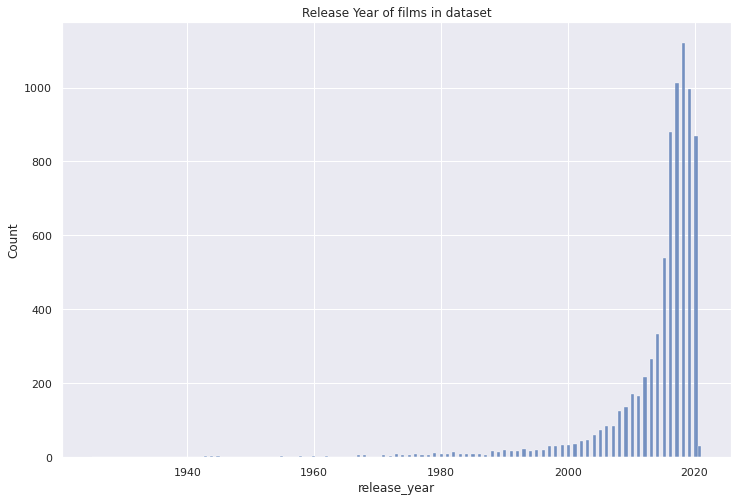

In [ ]:
# Visualizing the year in which the movie / tv show was released
plt.figure(figsize=(12,8))
sns.histplot(data=df,x='release_year')
plt.title("Release Year of films in dataset")

Netflix has greater number of new movies / TV shows than the old ones.

Text(0.5, 1.0, 'Top 10 genre of movies and shows in dataset')

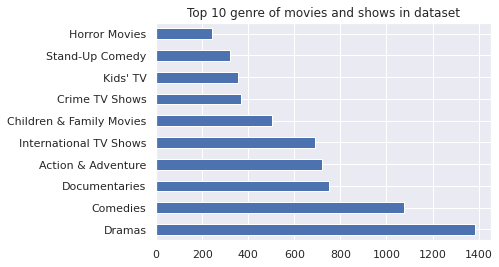

In [ ]:
# Top 10 genre
df['listed_in'].value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 genre of movies and shows in dataset")

In [ ]:
# Top 3 genres percentage
round(df['listed_in'].value_counts().nlargest(3).sum()/df.shape[0],2)

0.41

In [ ]:
# Top 10 genres percentage
round(df['listed_in'].value_counts().nlargest(10).sum()/df.shape[0],2)

0.82

- The dramas is the most popular genre followed by comedies and documentaries.
- These three genres account for about 41% of all movies and TV shows.
- This value increases to about 82% for top 10 genres.

Text(0.5, 1.0, 'Movies and shows added in each months over the years')

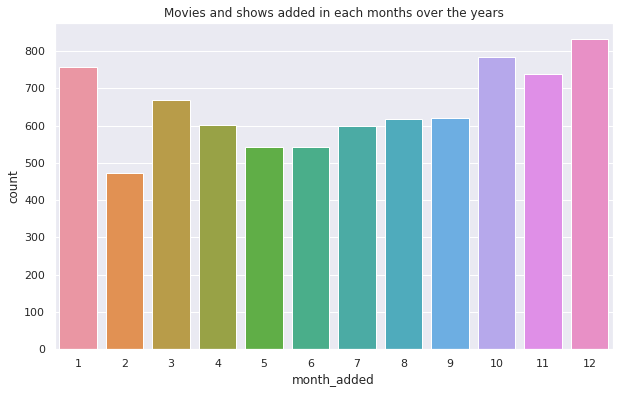

In [ ]:
# Number of shows added on different months
plt.figure(figsize=(10,6))
sns.countplot(df['month_added'])
plt.title("Movies and shows added in each months over the years")

- Over the years a greater number of shows were added in the months of October, November, December, and January.

Text(0.5, 0, '')

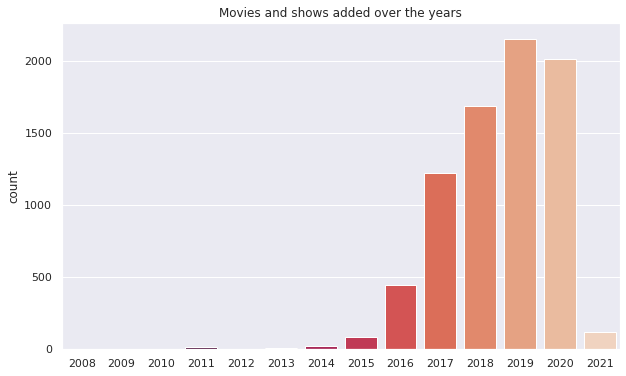

In [ ]:
# Number of shows added over the years
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='year_added',palette='rocket')
plt.title("Movies and shows added over the years")
plt.xlabel("")

- Netflix continuous to add more shows on its platform over the years.
- There is a decrease in the number of shows added in the year 2020, which might be attributed to the covid-19-induced lockdowns, which halted the creation of shows.
- We have Netflix data only up to 16th January 2021, hence there are less movies added in this year.

Bivariate Analysis

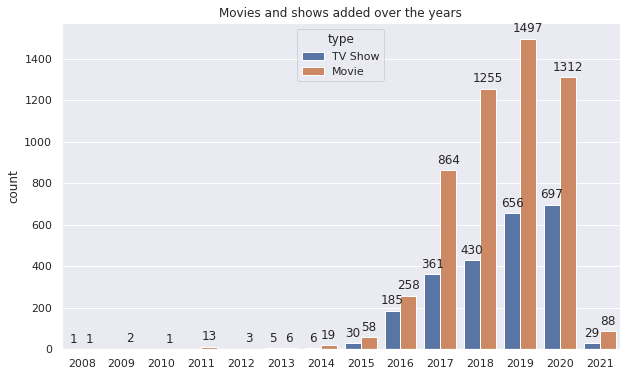

In [ ]:
# Number of movies and TV shows added over the years
plt.figure(figsize=(10,6))
p = sns.countplot(data=df,x='year_added',hue='type')
plt.title("Movies and shows added over the years")
plt.xlabel("")
for i in p.patches:
  p.annotate(format(i.get_height(),'.0f'),(i.get_x() + i.get_width()/2,i.get_height()),ha='center',va='center',xytext=(0,10),textcoords = 'offset points')

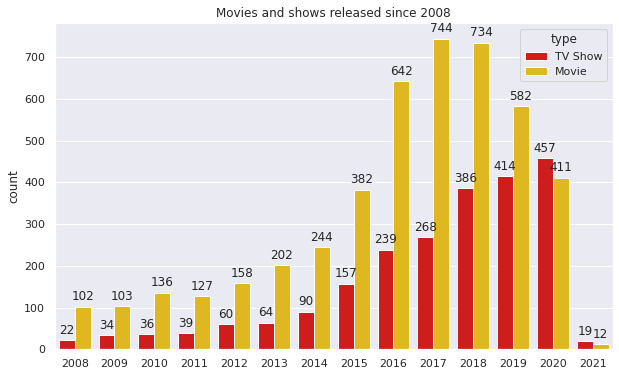

In [ ]:
# Number of shows released each year since 2008
order = range(2008,2022)
plt.figure(figsize=(10,6))
p = sns.countplot(data=df,x='release_year',hue='type',order=order,palette='hot')
plt.xlabel("")
plt.title("Movies and shows released since 2008")
for i in p.patches:
  p.annotate(format(i.get_height(),'.0f'),(i.get_x()+i.get_width()/2,i.get_height()),ha='center',va='center',xytext=(0,10),textcoords = 'offset points')

- Over the years, Netflix has consistently focused on adding more shows in its platform.
- Though there was a decrease in the number of movies added in 2018, this pattern did not exist in the number of TV shows added in the same year.
- This might signal that Netflix is increasingly concentrating on introducing more TV series to its platform rather than movies.

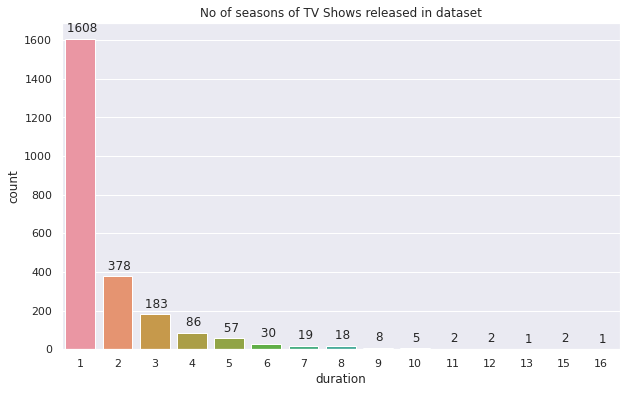

In [ ]:
# Seasons in each TV show
plt.figure(figsize=(10,6))
p = sns.countplot(df[df['type']=='TV Show']['duration'])
plt.title("No of seasons of TV Shows released in dataset")
for i in p.patches:
  p.annotate(format(i.get_height(),' .0f'),(i.get_x()+i.get_width()/2,i.get_height()),ha='center',va='center',xytext=(0,10),textcoords='offset points')

In [ ]:
# % of tv shows with just 1 season
len(df[(df['type']=='TV Show') & (df['duration']==1)])/len(df[df['type']=='TV Show'])* 100

67.0

- The TV series in the dataset have up to 16 seasons, however the bulk of them only have one. This might mean that the majority of TV shows has only recently begun, and that further seasons are on the way.
- There are very few TV shows that have more than 8 seasons.

Text(0.5, 1.0, 'Movie duration distribution')

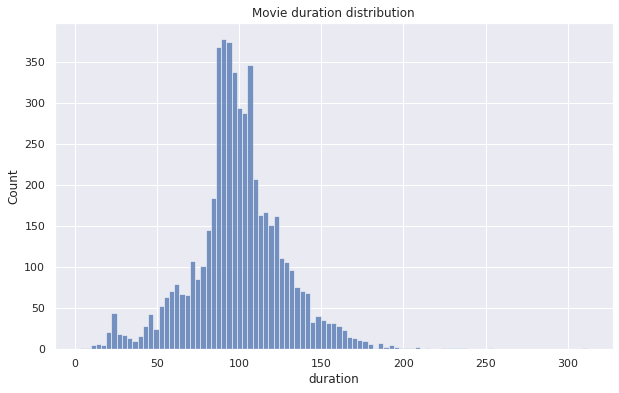

In [ ]:
# length of movie analysis
plt.figure(figsize=(10,6))
sns.histplot(data=df[df['type']=='Movie'],x='duration')
plt.title("Movie duration distribution")

In [ ]:
# Movie statistics
df[df['type']=='Movie']['duration'].describe()

count    5377.000000
mean       99.307978
std        28.530881
min         3.000000
25%        86.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration, dtype: float64

- The length of a movie may range from 3 min to 312 minutes, and the distribution is almost normally distributed.

Text(0.5, 0, 'Year')

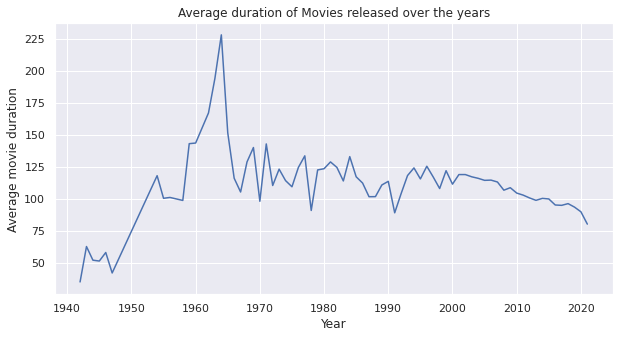

In [ ]:
# Average movie length over the years
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].groupby('release_year')['duration'].mean().plot(kind='line')
plt.title("Average duration of Movies released over the years")
plt.ylabel("Average movie duration")
plt.xlabel("Year")

In [ ]:
# Movie release year statistics
df[df['type']=='Movie']['release_year'].describe()

count    5377.000000
mean     2012.920030
std         9.663282
min      1942.000000
25%      2012.000000
50%      2016.000000
75%      2018.000000
max      2021.000000
Name: release_year, dtype: float64

- Netflix has several movies on its site, including those that were released in way back 1942.
- As per the plot, movies made in the 1940s had a fairly short duration on average.
- On average, movies made in the 1960s have the longest movie length.
- The average length of a movie has been continuously decreasing since the 2000s.

Text(0.5, 1.0, 'Top 10 geners of movies in dataset')

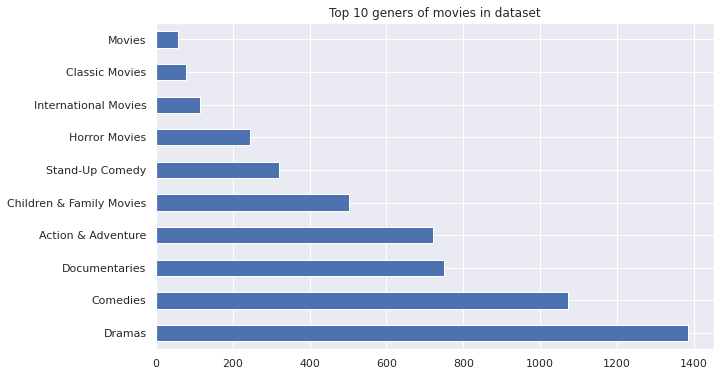

In [ ]:
# Top 10 genre for movies
plt.figure(figsize=(10,6))
df[df['type']=='Movie']['listed_in'].value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 geners of movies in dataset")

- Dramas, comedies, and documentaries are the most popular genre for the movies on Netflix.

Text(0.5, 1.0, 'Top 10 gener of TV Shows in dataset')

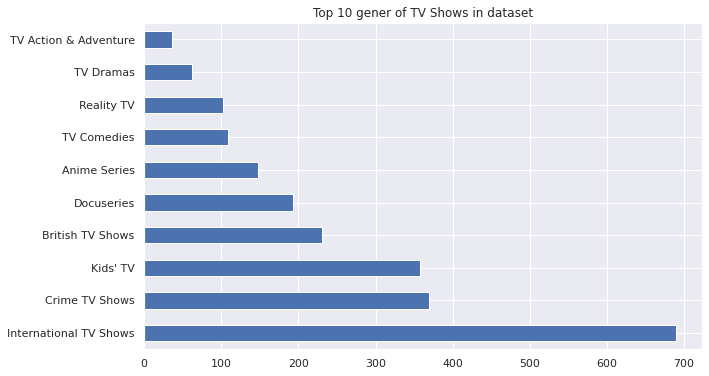

In [ ]:
# top 10 geners of TV Shows
plt.figure(figsize=(10,6))
df[df['type']=='TV Show']['listed_in'].value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 gener of TV Shows in dataset")

- International, crime, and kids are the most popular genre for TV shows on Netflix.


Text(0.5, 1.0, 'Top 10 directors with most movies in dataset')

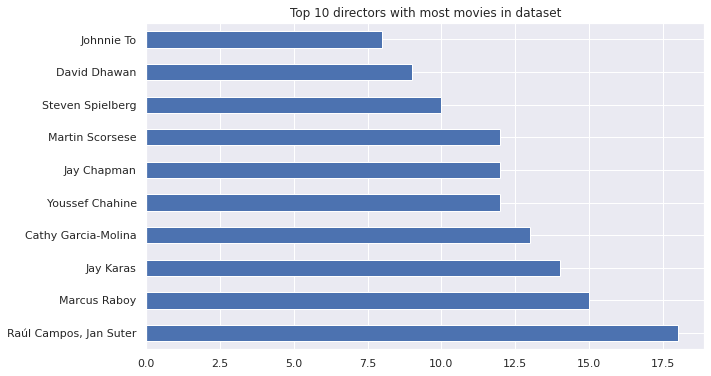

In [ ]:
# top 10 movie directors
plt.figure(figsize=(10,6))
df[~(df['director']=='unknown')&(df['type']=='Movie')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 directors with most movies in dataset")

- Raul Campos and Jan Suter have togather directed in 18 movies, higher than anyone yet.
- This is followed by Marcus Roboy, Jay Karas, and Cathy Gracia-Molina

Text(0.5, 1.0, 'Top 10 directors with most tv shows in dataset')

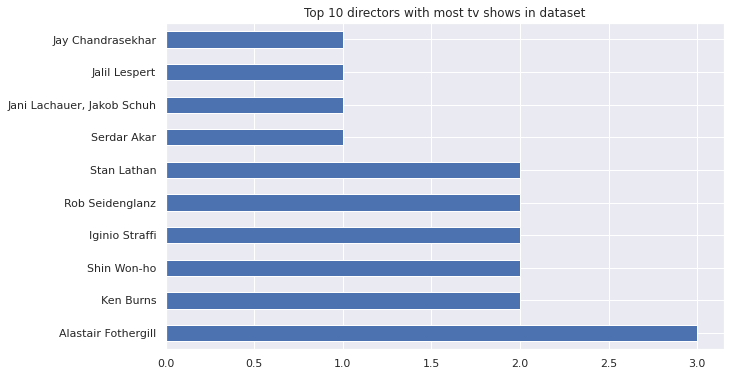

In [ ]:
# Top 10 directors with most Tv shows
plt.figure(figsize=(10,6))
df[~(df['director']=='unknown')&(df['type']=='TV Show')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 directors with most tv shows in dataset')

- Alastair Fothergill has directed three TV shows, the most of any director.
- Only six directors have directed more than one television show.

Text(0.5, 1.0, 'Top 10 actors with most movies in dataset')

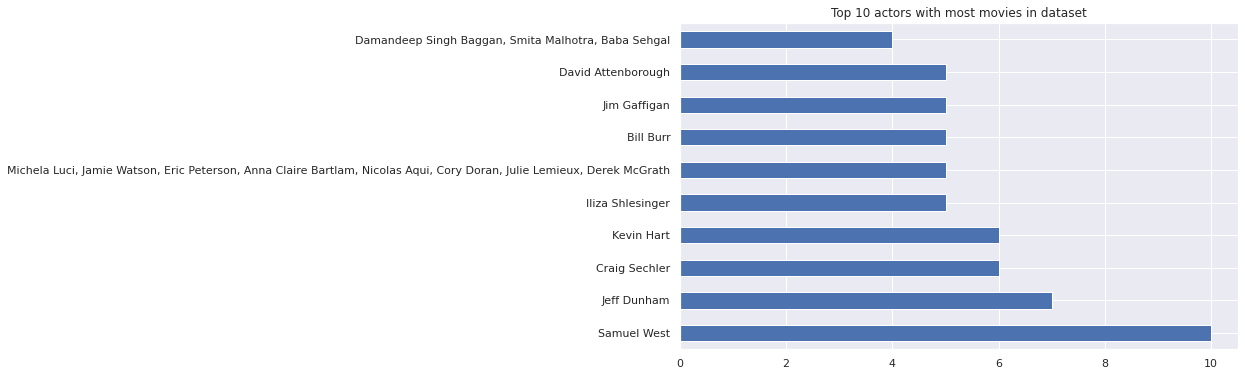

In [ ]:
# top 10 actors in movies
plt.figure(figsize=(10,6))
df[~(df['cast']=='unknown')&(df['type']=='Movie')].cast.value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 actors with most movies in dataset")

- Samuel West has appeared in 10 movies, followed by Jeff Dunham with 7 movies.

Text(0.5, 1.0, 'Top 10 actors with most TV Shows in dataset')

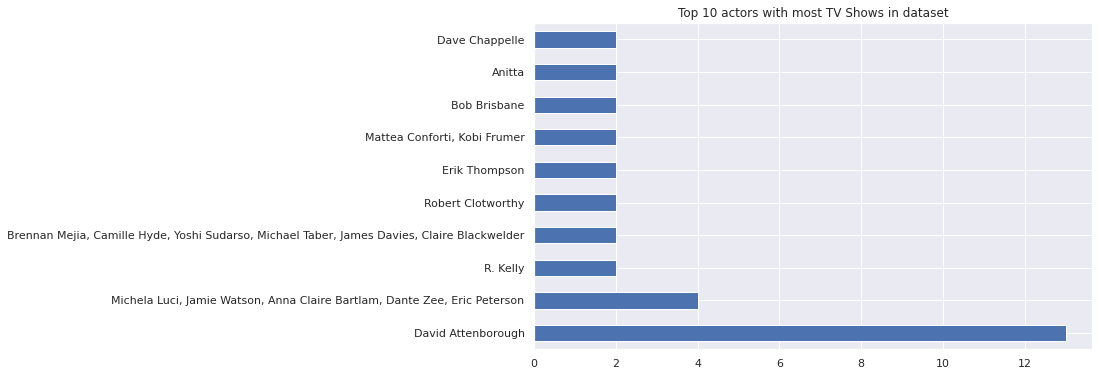

In [ ]:
# top 10 actors in tvshows
plt.figure(figsize=(10,6))
df[~(df['cast']=='unknown')&(df['type']=='TV Show')].cast.value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 actors with most TV Shows in dataset")

- David Attenborough has appeared in 13 TV shows, followed by Michela Luci, Jamie Watson, Anna Claire Bartlam, Dante Zee, Eric Peterson with 4 TV shows.

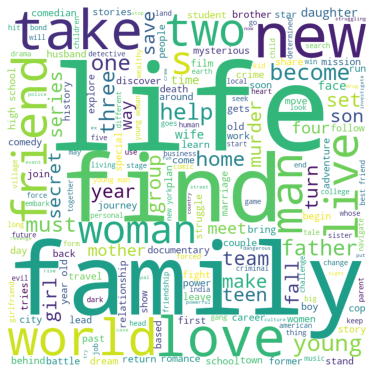

In [ ]:
# Building a wordcloud for the movie and tvshows description
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through csv file
for val in df.description.values:
  # typecaste each val to string
  val = str(val)
  # split the value
  tokens = val.split()
  #convert each token into lowercase
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width=700,height=700,background_color='white',stopwords=stopwords,min_font_size=10).generate(comment_words)

# plot the wordcloud image
plt.figure(figsize=(10,5),facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

- Some keywords in Netflix show descriptions: life, family, new, love, young, world, group, death, man, woman, murder, son, girl, documentary, secret.

6. Data Preprocessing

6.1. Modelling Approach:

1. Select the attributes based on which you want to cluster the shows
2. Text preprocessing: Remove all non-ascii characters, stopwords and punctuation marks, convert all textual data to lowercase.
3. Lemmatization to generate a meaningful word out of corpus of words
4. Tokenization of corpus
5. Word vectorization
6. Dimensionality reduction
7. Use different algorithms to cluster the movies, obtain the optimal number of clusters using different techniques
8. Build optimal number of clusters and visualize the contents of each cluster using wordclouds.

We will cluster the shows on Netflix based on the following attributes:

- Director
- Cast
- Country
- Listed in (genres)
- Description

In [ ]:
# Using the original dataset for clustering since
# it does not require handling missing values
df1 = original_data.copy()

In [ ]:
df1.fillna('',inplace=True)

In [ ]:
# Combining all clustering attributes into single column
df1['clustering_attributes'] = (df1['director'] + ' ' +
                                df1['cast'] + ' ' +
                                df1['country'] + ' ' +
                                df1['listed_in']+ ' '+
                                df1['description']+ ' ')

In [ ]:
df1['clustering_attributes'][10]

"Zak Hilditch Thomas Jane, Molly Parker, Dylan Schmid, Kaitlyn Bernard, Bob Frazer, Brian d'Arcy James, Neal McDonough United States Dramas, Thrillers A farmer pens a confession admitting to his wife's murder, but her death is just the beginning of a macabre tale. Based on Stephen King's novella. "

In [ ]:
df1['clustering_attributes'][40]

'Muharrem Gülmez Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem Gülmez, Elif Nur Kerkük, Tarık Papuççuoğlu, Suzan Aksoy, Doğa Konakoğlu, Esin Eden, Deniz Özerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall. '

- We have successfully added all the necessary data into a single column

6.2. Removing non-ASCII characters:

In [ ]:
# function to remove non-ascii characters

def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [ ]:
# remove non-ascii characters
df1['clustering_attributes'] = remove_non_ascii(df1['clustering_attributes'])

In [ ]:
df1['clustering_attributes'][10]

"Zak Hilditch Thomas Jane, Molly Parker, Dylan Schmid, Kaitlyn Bernard, Bob Frazer, Brian d'Arcy James, Neal McDonough United States Dramas, Thrillers A farmer pens a confession admitting to his wife's murder, but her death is just the beginning of a macabre tale. Based on Stephen King's novella. "

In [ ]:
df1['clustering_attributes'][40]

'Muharrem Gulmez Erdem Yener, Ayhan Tas, Emin Olcay, Muharrem Gulmez, Elif Nur Kerkuk, Tark Papuccuoglu, Suzan Aksoy, Doga Konakoglu, Esin Eden, Deniz Ozerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall. '

- We have successfully removed all non-ascii characters from the corpus.

6.3. Remove stopwords and lower case

In [ ]:
# Extracting the stopwords from nltk library
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')

# display the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [ ]:
# function to remove stopwords
def stopwords(text):
  """a function for removing stopwords"""
  # removing the stopwords and lowercasing the selected words
  text = [word.lower() for word in text.split() if word.lower() not in sw ]
  # joining the list of words with space seperator
  return " ".join(text)

In [ ]:
#Removing the stopwords
df1['clustering_attributes'] = df1['clustering_attributes'].apply(stopwords)

In [ ]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener, ayhan tas, emin olcay, muharrem gulmez, elif nur kerkuk, tark papuccuoglu, suzan aksoy, doga konakoglu, esin eden, deniz ozerman turkey comedies, international movies slacker owner public bath house rallies community save big developer comes town close open new mall.'

- We have successfully removed all the stopwords and converted the corpus to lowercase.

6.4. Remove punctuations

In [ ]:
def remove_punctuation(text):
  """a function to remove punctuations"""
  translator = str.maketrans('','',string.punctuation)
  # return the text stripped of punctuation mark
  return text.translate(translator)

In [ ]:
df1['clustering_attributes'] = df1['clustering_attributes'].apply(remove_punctuation)

In [ ]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener ayhan tas emin olcay muharrem gulmez elif nur kerkuk tark papuccuoglu suzan aksoy doga konakoglu esin eden deniz ozerman turkey comedies international movies slacker owner public bath house rallies community save big developer comes town close open new mall'

- We have successfully dropped all the punctuation marks from the corpus.


6.5. Lemmatization

In [ ]:
# function to lemmatize the corpus
def lemmatize_verbs(words):
  """Lemmmatize verbs in list of tokenized words"""
  lemmatizer = WordNetLemmatizer()
  lemmas = []
  for word in words:
    lemma = lemmatizer.lemmatize(word,pos='v')
    lemmas.append(lemma)
  return lemmas

In [ ]:
# Lemmatization
df1['clustering_attributes'] = lemmatize_verbs(df1['clustering_attributes'])

In [ ]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener ayhan tas emin olcay muharrem gulmez elif nur kerkuk tark papuccuoglu suzan aksoy doga konakoglu esin eden deniz ozerman turkey comedies international movies slacker owner public bath house rallies community save big developer comes town close open new mall'

- We have lemmatized the corpus.

6.6. Tokenization

In [ ]:
tokenizer = TweetTokenizer()


In [ ]:
df1['clustering_attributes'] = df1['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

- The corpus is converted to tokens

6.7. Vectorization

We can vectorize the corpus using TFIDF vectorizer, where TFIDF stands for - Term Frequency Inverse Document Frequency.

In [ ]:
# clustering tokens saved in variables
clustering_data = df1['clustering_attributes']

In [ ]:
#Tokenization
def identity_tokenizer(text):
  return text

#Using TFIDF vectorizer to vectorize rhe corpus
#max_features=20000 to prevent sytem from crashing

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,stop_words='english',lowercase=False,max_features=20000)

X = tfidf.fit_transform(clustering_data)

In [ ]:
X

<7787x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 235288 stored elements in Compressed Sparse Row format>

In [ ]:
X.shape

(7787, 20000)

In [ ]:
type(X)

scipy.sparse.csr.csr_matrix

In [ ]:
X = X.toarray()

6.8. Dimensionality reduction using PCA

- We can use PCA (Principal component Analysis) to reduce the dimensionality of data

In [ ]:
# using PCA to reduce dimensionality
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

Text(0, 0.5, 'Cumulative explained variance')

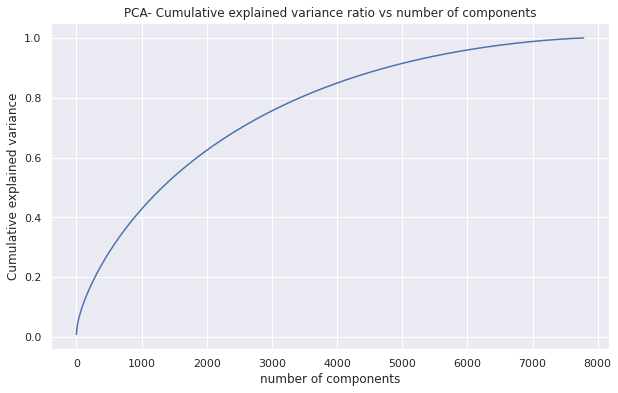

In [ ]:
# Explained variance for differnt number of components
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA- Cumulative explained variance ratio vs number of components")
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")

- We find that 100% of the variance is explained by about ~7500 components.
- Also, more than 80% of the variance is explained just by 4000 components.
- Hence to simplify the model, and reduce dimensionality, we can take the top 4000 components, which will still be able to capture more than 80% of variance.

In [ ]:
# reducing the dimensions to 4000 using pca
pca = PCA(n_components=4000,random_state=42)
pca.fit(X)

PCA(n_components=4000, random_state=42)

In [ ]:
# transformed_features
x_pca = pca.transform(X)

In [ ]:
# shape of transformed vector
x_pca.shape

(7787, 4000)

-We have successfully reduced the dimensionality of data using PCA.

7. Clusters implementation

7.1. K-Means Clustering

Building clusters using the K-means clustering algorithm.

Visualizing the elbow curve and Silhouette score to decide on the optimal number of clusters for K-means clustering algorithm.

In [ ]:
# Elbow method to find the optimal value of k
wcss = []
for i in range(1,21):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

Text(0.5, 1.0, 'The Elbow Method - KMeans clustering')

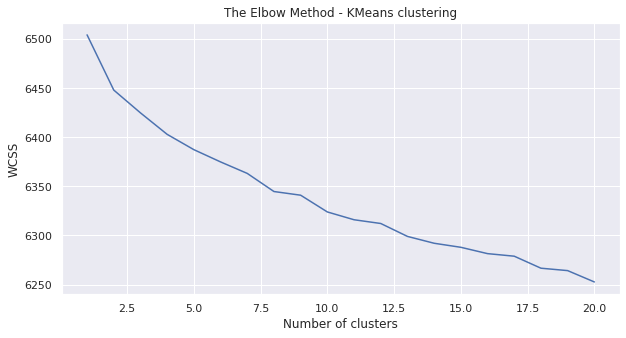

In [ ]:
number_clusters = range(1,21)
plt.figure(figsize=(10,5))
plt.plot(number_clusters,wcss)
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("The Elbow Method - KMeans clustering")

- The sum of squared distance between each point and the centroid in a cluster (WCSS) decreases with the increase in the number of clusters.

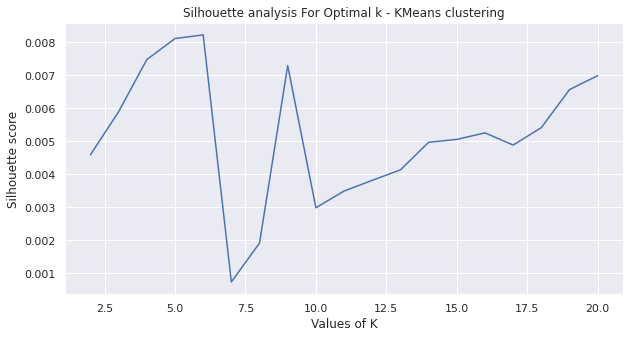

In [ ]:
# plotting Silhouette score for different number of clusters
# Plotting Silhouette score for different umber of clusters
range_n_clusters = range(2,21)
silhouette_avg = []
for num_clusters in range_n_clusters:
  # initialize kmeans
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  cluster_labels = kmeans.labels_

  # silhouette score
  silhouette_avg.append(silhouette_score(x_pca, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k - KMeans clustering')
plt.show()

- The highest Silhouette score is obtained for 6 clusters.

- Building 6 clusters using the k-means clustering algorithm:

In [ ]:
# clustering the data into 6 clusters
kmeans = KMeans(n_clusters =6,init='k-means++',random_state=33)
kmeans.fit(x_pca)

KMeans(n_clusters=6, random_state=33)

In [ ]:
# Evalustion metrics-distortion, Silhouette Score
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(x_pca,kmeans.labels_)

print(kmeans_distortion,kmeans_silhouette_score)

6374.780433241613 0.008224786779751518


In [ ]:
# adding kmeans cluster number attributes
df1['kmeans_cluster'] = kmeans.labels_

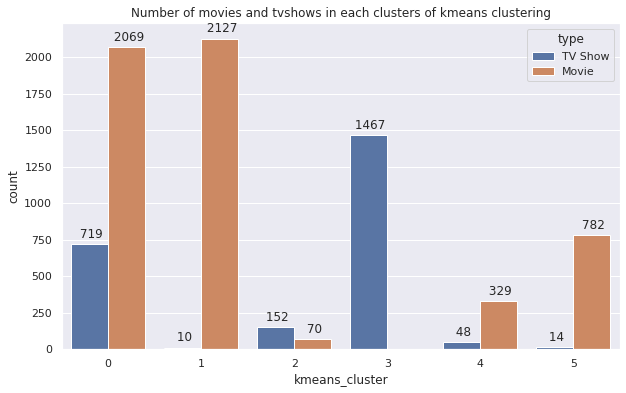

In [ ]:
# number of movies and tvshows in each cluster
plt.figure(figsize=(10,6))
q = sns.countplot(data=df1,x='kmeans_cluster',hue='type')
plt.title("Number of movies and tvshows in each clusters of kmeans clustering")
for i in q.patches:
  q.annotate(format(i.get_height(),' .0f'),(i.get_x()+i.get_width()/2.,i.get_height()),ha='center',va='center',xytext=(0,10),textcoords='offset points')

- Successfully built 6 clusters using the k-means clustering algorithm

7.1.1. Building wordclouds for different clusters built:

In [ ]:
# building a wordcloud for the movies and tvshows in descriptions

def kmeans_wordcloud(cluster_num):
  comment_words = ""
  stopwords = set(STOPWORDS)
  # iterate through csv files
  for val in df1[df1['kmeans_cluster']==cluster_num].description.values:

    #typecaste each value to string
    val = str(val)

    # split the values
    tokens = val.split()

    # convert each token into lowercase
    for i in range(len(tokens)):
      tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+ " "

  wordcloud = WordCloud(width=700,height=700,
                        background_color='white',
                        stopwords=stopwords,
                        min_font_size=10).generate(comment_words)

  # Plot the wordcloud image
  plt.figure(figsize=(10,5),facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad=0)

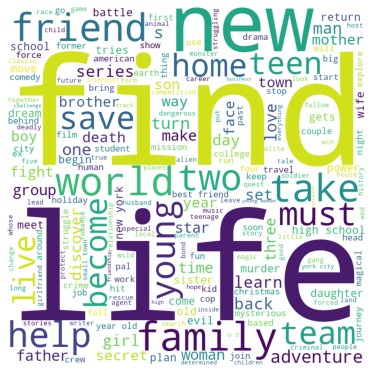

In [ ]:
# Wordcloud for cluster 0
kmeans_wordcloud(0)

- Keywords observed in cluster 0: life, new, family, friend, save, help, discover, home, teen

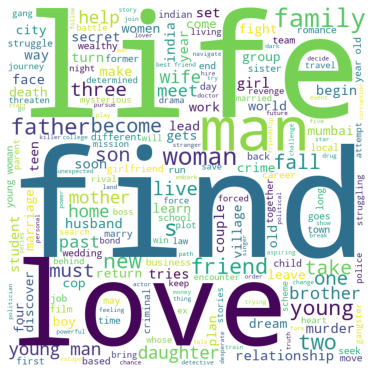

In [ ]:
# Wordcloud for cluster 1
kmeans_wordcloud(1)

- Keywords observed in cluster 1: life, love, family, father, young, girl, man, woman, friend, daughter

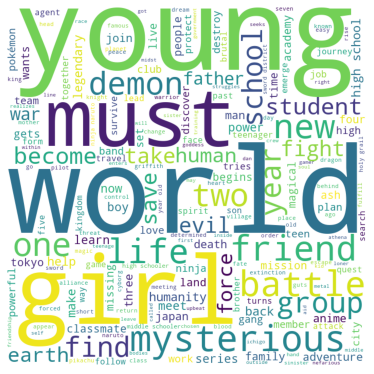

In [ ]:
# Wordcloud for cluster 2
kmeans_wordcloud(2)

- Keywords observed in cluster 2: young, world, girl, mysterious, humanity, life, student, school, battle, demon, force

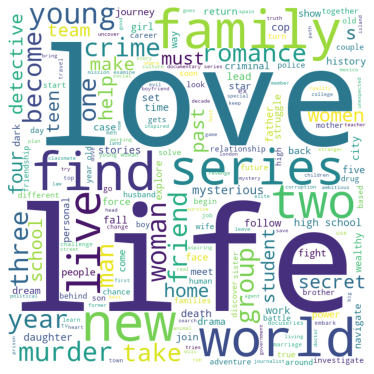

In [ ]:
# Wordcloud for cluster 3
kmeans_wordcloud(3)

- Keywords observed in cluster 3: love, life, family, romance, crime, murder, world, adventure

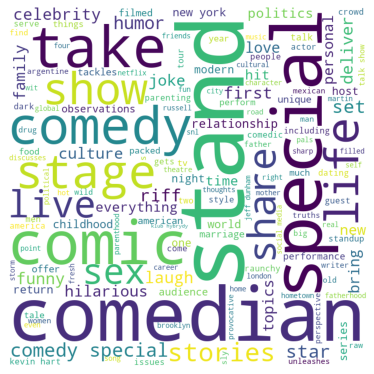

In [ ]:
# Wordcloud for cluster 4
kmeans_wordcloud(4)

- Keywords observed in cluster 4: comedian, special, stand, comic, stage, sex, joke

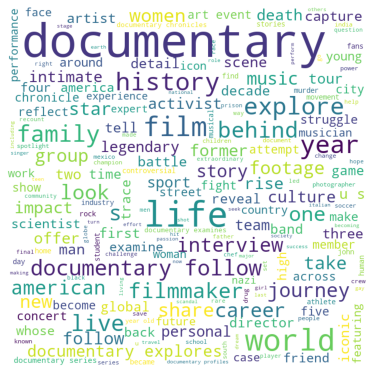

In [ ]:
# Wordcloud for cluster 5
kmeans_wordcloud(5)

- Keywords observed in cluster 5: documentary, world, life, filmmaker, american, life

7.2. Hierarchical clustering

Building clusters using the agglomerative (hierarchical) clustering algorithm

Visualizing the dendrogram to decide on the optimal number of clusters for the agglomerative (hierarchical) clustering algorithm:

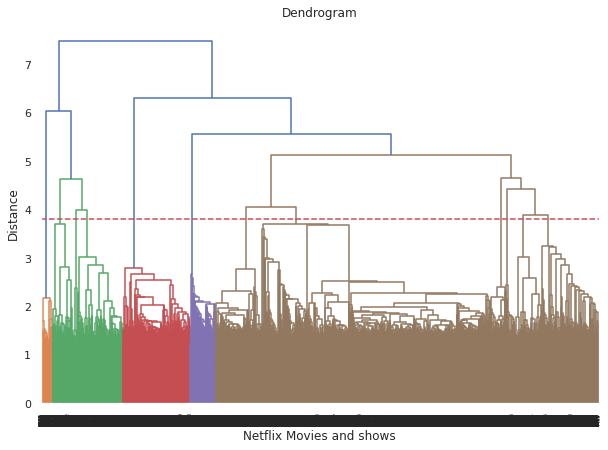

In [ ]:
# Building a dendrogram to decide on the number of clusters
plt.figure(figsize=(10,7))
dend = shc.dendrogram(shc.linkage(x_pca,method='ward'))
plt.title("Dendrogram")
plt.xlabel("Netflix Movies and shows")
plt.ylabel('Distance')
plt.axhline(y=3.8,color='r',linestyle='--')

At a distance of 3.8 units, 12 clusters can be built using the agglomerative clustering algorithm.

Building 12 clusters using the Agglomerative clustering algorithm:

In [ ]:
# Filtering hierarchical clustering model
hierarchical = AgglomerativeClustering(n_clusters=12,affinity='euclidean',linkage='ward')
hierarchical.fit_predict(x_pca)

array([3, 5, 1, ..., 4, 2, 4])

In [ ]:
#adding a hierarchical cluster number attributes
df1['hierarchical_cluster'] = hierarchical.labels_

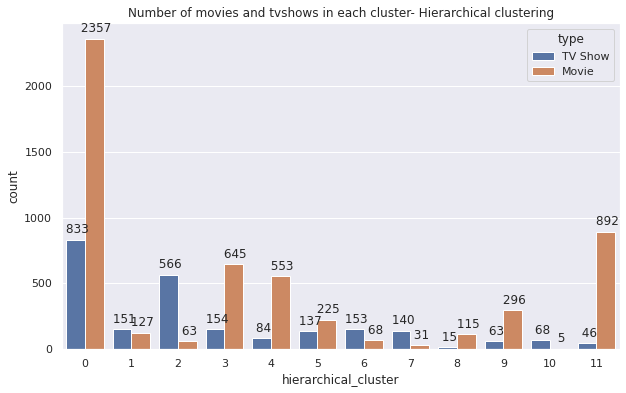

In [ ]:
# Number of movies and tvshows in each cluster
plt.figure(figsize=(10,6))
q = sns.countplot(data=df1,x='hierarchical_cluster' ,hue='type')
plt.title("Number of movies and tvshows in each cluster- Hierarchical clustering")

for i in q.patches:
  q.annotate(format(i.get_height(),' .0f'),(i.get_x()+ i.get_width()/2.,i.get_height()),ha='center',va='center',xytext=(0,10),textcoords='offset points')

Successfully built 12 clusters using the Agglomerative (hierarchical) clustering algorithm.

7.2.1. Building wordclouds for different clusters built:

In [ ]:
# Building a wordcloud for the movie descriptions
def hierarchical_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['hierarchical_cluster']==cluster_num].description.values:

      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()

      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()

      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)

  # plot the WordCloud image
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

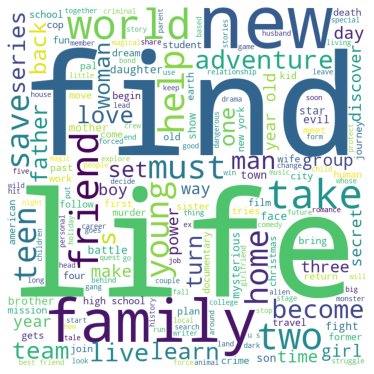

In [ ]:
# Wordcloud for cluster 0
hierarchical_worldcloud(0)

- Keywords observed in cluster 0: life, new, find, family, save, friend, young, teen, adventure

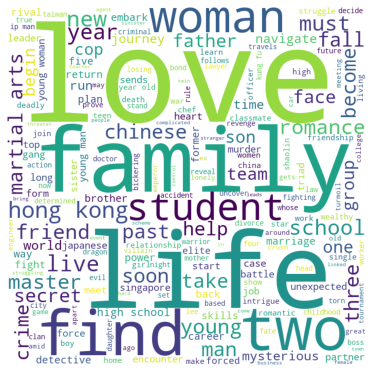

In [ ]:
# Wordcloud for cluster 1
hierarchical_worldcloud(1)

- Keywords observed in cluster 1: love, family, life, student, romance, school, woman, master, father

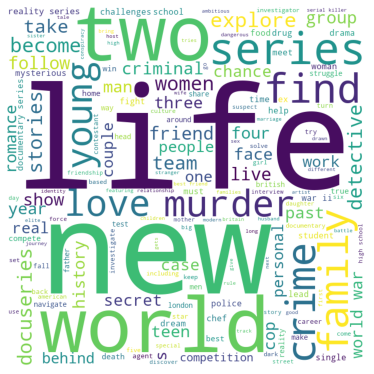

In [ ]:
# Wordcloud for cluster 2
hierarchical_worldcloud(2)

- Keywords observed in cluster 2: life, new, series, crime, world, murder, history, detective

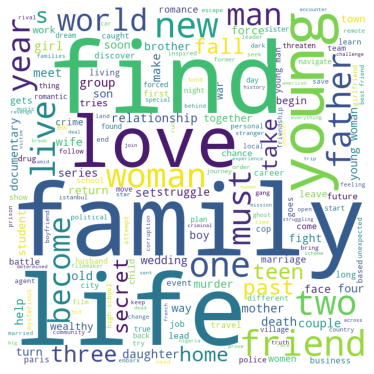

In [ ]:
# Wordcloud for cluster 3
hierarchical_worldcloud(3)

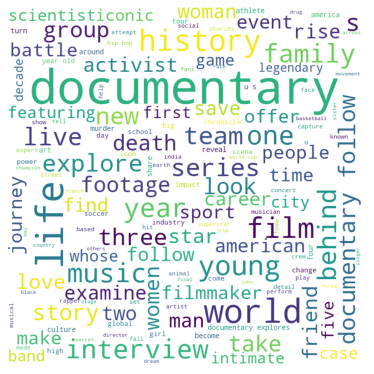

In [ ]:
# Wordcloud for cluster 4
hierarchical_worldcloud(4)

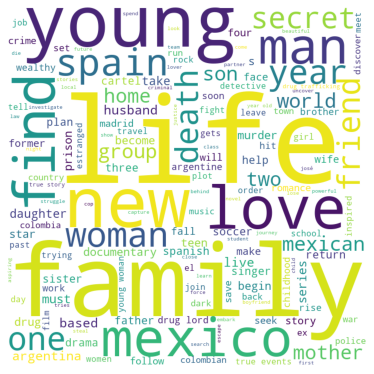

In [ ]:
# Wordcloud for cluster 5
hierarchical_worldcloud(5)

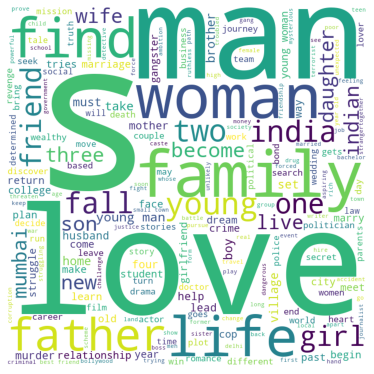

In [ ]:
# Wordcloud for cluster 11
hierarchical_worldcloud(11)

- Keywords observed in cluster 11: love, man, woman, india, father, friend, girl, mumbai, city, learn, young

8. Content based recommender system:

- We can build a simple content based recommender system based on the similarity of the shows.
- If a person has watched a show on Netflix, the recommender system must be able to recommend a list of similar shows that s/he likes.
- To get the similarity score of the shows, we can use cosine similarity
- The similarity between two vectors (A and B) is calculated by taking the dot product of the two vectors and dividing it by the magnitude value as shown in the equation below. We can simply say that the CS score of two vectors increases as the angle between them decreases.



In [ ]:
# defining a new df for building a recommendation system
recommender_df2 = df1.copy()

In [ ]:
# changing the index of the df from show id to title id
recommender_df2['show_id'] = recommender_df2.index

In [ ]:
# converting tokens to string
def convert(lst):
  return ' '.join(lst)

recommender_df2['clustering_attributes'] = recommender_df2['clustering_attributes'].apply(lambda x: convert(x))

In [ ]:
# setting title of movies/tvshows as index
recommender_df2.set_index('title',inplace=True)

In [ ]:
#Count Vectorizer
CV = CountVectorizer()
converted_matrix = CV.fit_transform(recommender_df2['clustering_attributes'])

In [ ]:
# Cosine similarity
cosine_similarity = cosine_similarity(converted_matrix)

In [ ]:
cosine_similarity.shape

(7787, 7787)

In [ ]:
# Developing a function to get 10 recommendations for a show
indices = pd.Series(recommender_df2.index)

def recommend_10(title, cosine_sim = cosine_similarity):
  try:
    recommend_content = []
    idx = indices[indices == title].index[0]
    series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top10 = list(series.iloc[1:11].index)
    # list with the titles of the best 10 matching movies
    for i in top10:
      recommend_content.append(list(recommender_df2.index)[i])
    print("If you liked '"+title+"', you may also enjoy:\n")
    return recommend_content

  except:
    return 'Invalid Entry'

In [ ]:
# Recommendations for 'A Man Called God'
recommend_10('A Man Called God')

If you liked 'A Man Called God', you may also enjoy:



['Mr. Sunshine',
 'One Spring Night',
 'Rugal',
 'The King: Eternal Monarch',
 'My Mister',
 'My Little Baby',
 'Reply 1994',
 'Extracurricular',
 'My Secret Romance',
 'Chef & My Fridge']

In [ ]:
# Recommendations for 'Lucifer'
recommend_10('Lucifer')

If you liked 'Lucifer', you may also enjoy:



['Rica, Famosa, Latina',
 'Get Shorty',
 'The Good Cop',
 'Jack Taylor',
 'Better Call Saul',
 'Dramaworld',
 'Father Brown',
 "Marvel's Iron Fist",
 'Young Wallander',
 'No Good Nick']

Conclusions

- In this project, we worked on a text clustering problem wherein we had to classify/group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.
- The dataset contained about 7787 records, and 11 attributes.
- We began by dealing with the dataset's missing values and doing exploratory data analysis (EDA).
- It was found that Netflix hosts more movies than TV shows on its platform, and the total number of shows added on Netflix is growing exponentially. Also, majority of the shows were produced in the United States, and the majority of the shows on Netflix were created for adults and young adults age group.
- It was decided to cluster the data based on the attributes: director, cast, country, genre, and description. The values in these attributes were tokenized, preprocessed, and then vectorized using TFIDF vectorizer.
- Through TFIDF Vectorization, we created a total of 20000 attributes.
- We used Principal Component Analysis (PCA) to handle the curse of dimensionality. 4000 components were able to capture more than 80% of variance, and hence, the number of components were restricted to 4000.
- We first built clusters using the k-means clustering algorithm, and the optimal number of clusters came out to be 6. This was obtained through the elbow method and Silhouette score analysis.
- Then clusters were built using the Agglomerative clustering algorithm, and the optimal number of clusters came out to be 12. This was obtained after visualizing the dendrogram.
- A content based recommender system was built using the similarity matrix obtained after using cosine similarity. This recommender system will make 10 recommendations to the user based on the type of show they watched.